Install additional packages

In [1]:
!pip install pyarrow

     |████████████████████████████████| 17.7 MB 3.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
# Changes on custom modules will be automatically reloaded
%load_ext autoreload
%autoreload 2

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, we will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. We'll use unsupervised learning techniques (dimensionality reduction + clustering) to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, we'll apply what was learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [93]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from scipy.spatial.distance import cdist

# magic word for producing visualizations in notebook
%matplotlib inline

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import os, sys
sys.path.append('.')

import utils

## Part 1: Customer Segmentation Report

The main bulk of the analysis comes in this part of the project. Here, it shall be use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, it shall be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [7]:
# AWS libraries
import boto3
import sagemaker
import mxnet as mx

from sagemaker import PCA, KMeans, get_execution_role

In [8]:
# get a references to S3 data and model bucket
data_bucket = utils.BucketUtils(bucket_name='arvatos-capstone', prefix = 'data')
models_bucket = utils.BucketUtils(bucket_name='arvatos-capstone', prefix = 'models')

In [9]:
# store the current SageMaker session
session = sagemaker.Session()

# get IAM role
role = get_execution_role()
print('Role: %s' % role)

print('Bucket: %s' % data_bucket.bucket_name)
print()

Role: arn:aws:iam::089812661404:role/service-role/AmazonSageMaker-ExecutionRole-20201010T192233
Bucket: arvatos-capstone



### Read Data

In [10]:
azdias_mm = data_bucket.read_parquet('Udacity_AZDIAS_052018_mm.parquet')
azdias_std = data_bucket.read_parquet('Udacity_AZDIAS_052018_std.parquet')
azdias_mm.sample(7)

,NUM_CHILDREN,T_AMOUNT_ONLINE_BANK_12M,B_NUM_ACADEMICS_BUILDING,T_AMOUNT_ONLINE_INSURANCE_12M,HH_RECOVERED_YEAR,URBAN_AGGLOMERATION,HH_NUM_ADULTS,HH_HOUSEHOLD_STATS,NH_NUMBER_CARS_PLZ8,T_AMOUNT_ONLINE_MAILORDER_12M,...,P_LIFESTAGE_ROUGH_2,P_LIFESTAGE_ROUGH_3,P_LIFESTAGE_ROUGH_4,NH_NEIGHBORHOOD_SCORE_1,NH_NEIGHBORHOOD_SCORE_2,NH_NEIGHBORHOOD_SCORE_3,VK_ZG11_1,VK_ZG11_2,VK_ZG11_3,VK_ZG11_4
373044,0.090909,0.0,0.0,0.0,0.838983,0.022222,0.022222,0.011136,0.162174,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
32355,0.000000,0.0,0.0,0.0,0.796610,1.000000,0.044444,0.002227,0.200000,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
603547,0.000000,0.0,0.0,0.0,0.940678,0.000000,0.022222,0.017817,0.338696,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
260934,0.000000,0.0,0.0,0.0,0.847458,0.977778,0.022222,0.022272,0.277391,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
152973,0.000000,0.0,0.0,0.0,0.974576,0.088889,0.044444,0.013363,0.238696,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
579590,0.090909,0.0,0.0,0.0,0.966102,0.000000,0.066667,0.002227,0.139565,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
175244,0.000000,0.0,0.0,0.0,0.957627,0.000000,0.022222,0.017817,0.130435,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


#### Save features list before PCA Transformation

In [12]:
features_list = azdias_mm.columns.values
utils.pickle_obj(features_list, 'encoded_features_list')

## Dimensionality Reduction

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as *weighted*, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data! You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.

We can reduce dimensionality with the built-in SageMaker model for [PCA](http://sagemaker.readthedocs.io/en/latest/pca.html).


#### Create PCA estimators instances

In [13]:
# define location to store model artifacts
output_path='s3://{}/{}/'.format(models_bucket.bucket_name, models_bucket.prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://arvatos-capstone/models/


In [14]:
# Since we don't know the number of components beforehand, let's define as number of features -1
# Latter on, we'll select only a portion of these to use
N_COMPONENTS=len(azdias_mm.columns)-1

pca_SM_mm = PCA(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # specified, above
                num_components=N_COMPONENTS,
                sagemaker_session=session)


pca_SM_std = PCA(role=role,
                 train_instance_count=1,
                 train_instance_type='ml.c4.xlarge',
                 output_path=output_path, # specified, above
                 num_components=N_COMPONENTS,
                 sagemaker_session=session)

#### Data preparation
Prepare the data for a built-in model by converting the DataFrame to a numpy array of float values and then convert it into a **RecordSet** format that is the required format for the training input data. This is a requirement for _all_ of SageMaker's built-in models.

In [15]:
# convert df to np array
train_data_mm_np = azdias_mm.values.astype('float32')
train_data_std_np = azdias_std.values.astype('float32')
#train_data_np = transformed_df.values

# convert to RecordSet format
formatted_train_data_mm = pca_SM_mm.record_set(train_data_mm_np)
formatted_train_data_std = pca_SM_std.record_set(train_data_std_np)

## Train the model

In [16]:
%%time

# train the PCA mode on the formatted data
pca_SM_mm.fit(formatted_train_data_mm, logs=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 21:36:10 Starting - Starting the training job
2020-10-25 21:36:12 Starting - Launching requested ML instances................
2020-10-25 21:37:39 Starting - Preparing the instances for training...............
2020-10-25 21:38:59 Downloading - Downloading input data....
2020-10-25 21:39:25 Training - Downloading the training image..
2020-10-25 21:39:39 Training - Training image download completed. Training in progress...
2020-10-25 21:39:55 Uploading - Uploading generated training model
2020-10-25 21:40:01 Completed - Training job completed
CPU times: user 227 ms, sys: 31.6 ms, total: 259 ms
Wall time: 3min 51s


In [17]:
%%time

# train the PCA mode on the formatted data
pca_SM_std.fit(formatted_train_data_std, logs=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 21:40:02 Starting - Starting the training job
2020-10-25 21:40:05 Starting - Launching requested ML instances.............
2020-10-25 21:41:16 Starting - Preparing the instances for training.............
2020-10-25 21:42:26 Downloading - Downloading input data.......
2020-10-25 21:43:05 Training - Downloading the training image..
2020-10-25 21:43:19 Training - Training image download completed. Training in progress...
2020-10-25 21:43:35 Uploading - Uploading generated training model
2020-10-25 21:43:41 Completed - Training job completed
CPU times: user 241 ms, sys: 6.75 ms, total: 248 ms
Wall time: 3min 41s


Cleanup some memory

In [18]:
del azdias_mm
del azdias_std

del formatted_train_data_mm
del formatted_train_data_std

### Accessing the PCA Model Attributes

After the model is trained, we can access the underlying model parameters.<br>
Model artifacts are stored in S3 as a TAR file; a compressed file in the output path we specified + 'output/model.tar.gz'. The artifacts stored here can be used to deploy a trained model.

**PCA Model Attributes**

Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
We are only interested in v and s. 

From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

From v, we can learn more about the combinations of original features that make up each principal component.

In [19]:
def get_model_attributes(pca_model, bucket):
    """
    Download and extract PCA model attributes (eigenvalues and eigenvectors)
    ---
    Arguments
        pca_model: sagemaker.PCA
            A trained PCA estimator
        bucket: BucketUtils
            Bucket instance where model artifacts are stored
    Returns
        s,v: tuple of pd.DataFrames
            A tuple of dataframes containing eigenvalues and eigenvectors from pca model
    """
    # Get the name of the training job from pca_model predictor
    training_job_name=pca_model._current_job_name

    # where the model is saved, by default
    model_key = os.path.join(bucket.prefix, training_job_name, 'output/model.tar.gz')
    print(model_key)

    # download and unzip model
    boto3.resource('s3').Bucket(bucket.bucket_name).download_file(model_key, 'model.tar.gz')

    # unzipping as model_algo-1
    os.system('tar -zxvf model.tar.gz')
    os.system('unzip model_algo-1')
    
    # loading the unzipped artifacts
    pca_model_params = mx.ndarray.load('model_algo-1')
    
    # get selected params
    ## s: eigenvalues
    ## v: eigenvectors
    s=pd.DataFrame(pca_model_params['s'].asnumpy())
    v=pd.DataFrame(pca_model_params['v'].asnumpy())
    
    return s, v

In [21]:
# save attributes from PCA model trained with normalized data
mm_s, mm_v = get_model_attributes(pca_SM_mm, models_bucket)

mm_s.to_csv('pca_mm__s_%s' % pca_SM_mm._current_job_name)
mm_v.to_csv('pca_mm__v_%s' % pca_SM_mm._current_job_name)
mm_job_name = pca_SM_mm._current_job_name
print(mm_job_name)

models/pca-2020-10-25-21-36-10-421/output/model.tar.gz
pca-2020-10-25-21-36-10-421


In [22]:
# save attributes from PCA model trained with standardized data
std_s, std_v = get_model_attributes(pca_SM_std, models_bucket)

std_s.to_csv('pca_std__s_%s' % pca_SM_std._current_job_name)
std_v.to_csv('pca_std__v_%s' % pca_SM_std._current_job_name)
std_job_name = pca_SM_std._current_job_name
print(std_job_name)

models/pca-2020-10-25-21-40-01-927/output/model.tar.gz
pca-2020-10-25-21-40-01-927


### Data Variance

Our current PCA model creates 417 principal components, but when we create new dimensionality-reduced training data, we'll only select a few, top n components to use. To decide how many top components to include, it's helpful to look at how much **data variance** the components capture. For our original, high-dimensional data, 418 features captured 100% of our data variance. If we discard some of these higher dimensions, we will lower the amount of variance we can capture.

When we select the top n components to use in a new data model, we'll typically want to include enough components to capture about 80-90% of the original data variance. In this project, we are looking at generalizing over a lot of data and we'll aim for about 80% coverage.

**Note**: The _top_ principal components, with the largest s values, are actually at the end of the s DataFrame. Let's print out the s values for the top n, principal components.

#### Calculate and plot the explained variance

In [23]:
def explained_variance(s, n_top_components):
    """
    Calculates the approximate data variance that n_top_components captures.
    Assumes access to global N_COMPONENTS variable
    ---
    Arguments
        s: pd.DataFrame
            A dataframe of singular values for top components. The top value is in the last row.
        n_top_components: int
            The number of top components to use.
    Returns
        exp_variance: float
            The expected data variance covered by the n_top_components
    """
    start_idx = N_COMPONENTS - n_top_components  ## 33-3 = 30, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

### Test Cell

Test out your own code by seeing how it responds to different inputs; does it return a reasonable value for the single, top component? What about for the top 5 components?

In [24]:
def plot_explained_variance(s, target_variance=0.85):
    """
    Plot the explained variance x number of components, returning the number of
    components at target variance.
    Assumes access to global N_COMPONENTS variable
    ---
    Arguments
        s: pd.DataFrame
            A dataframe of singular values for top components. The top value is in the last row.
        target_variance: float
            The number of top components to use.
    Returns
        n_components: int
            The number of components required for target_variance
    """    
    exp_variances = []
    N_COMPONENTS = len(s)
    for n_top_components in range(N_COMPONENTS):
        # calculate the explained variance
        exp_variance = explained_variance(s, n_top_components)
        exp_variances.append(exp_variance)

    n_components = np.sum(np.array(exp_variances) <= target_variance)
    ax = sns.lineplot(list(range(N_COMPONENTS)), exp_variances)
    ax.set_xlabel('Components')
    ax.set_xlabel('Variance')
    _ = ax.set_title('Explained Variance - target at %d components' % n_components)
    
    return n_components

Explained variance plot for PCA model trained on normalized data

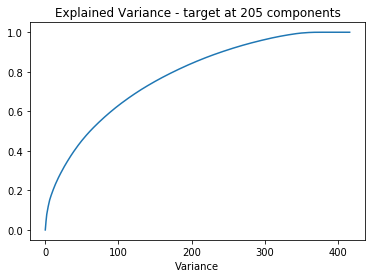

In [25]:
mm_components = plot_explained_variance(mm_s, target_variance=0.85)

Explained variance plot for PCA model trained on standardized data

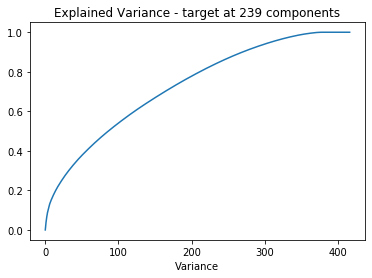

In [26]:
std_components = plot_explained_variance(std_s, target_variance=0.85)

In [27]:
print('MM: Number of PCA components to preserve 0.85 of variance: %d' % mm_components)
print('STD: Number of PCA components to preserve 0.85 of variance: %d' % std_components)

MM: Number of PCA components to preserve 0.85 of variance: 205
STD: Number of PCA components to preserve 0.85 of variance: 239


From now on, we shall consider normalized data and mm_components (205)

#### Component Makeup

We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component. 

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [28]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    """
    Plot the explained variance x number of components, returning the number of
    components at target variance.
    Assumes access to global N_COMPONENTS variable
    ---
    Arguments
        s: pd.DataFrame
            A dataframe of singular values for top components. The top value is in the last row.
        target_variance: float
            The number of top components to use.
    Returns
        n_components: int
            The number of components required for target_variance
    """
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


Component makeup for top 10 PCA components, normalized data

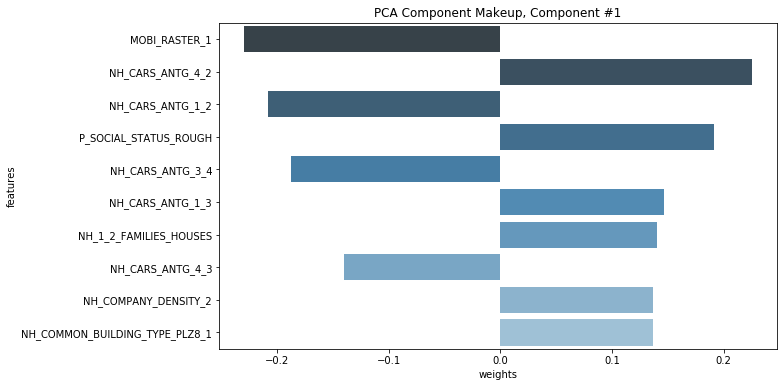

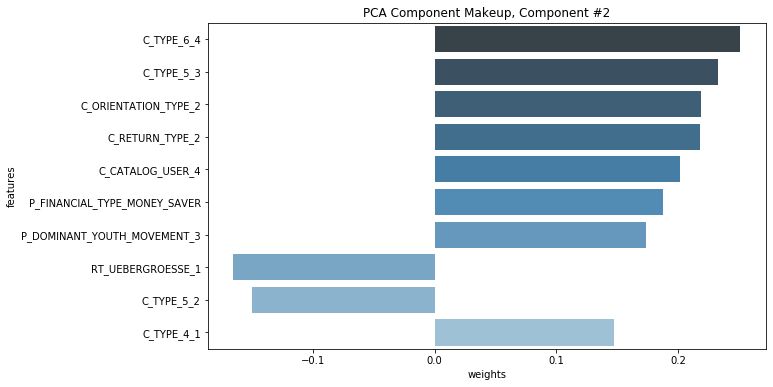

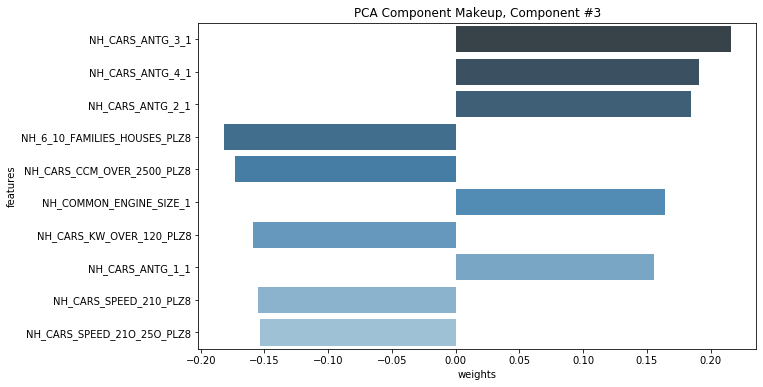

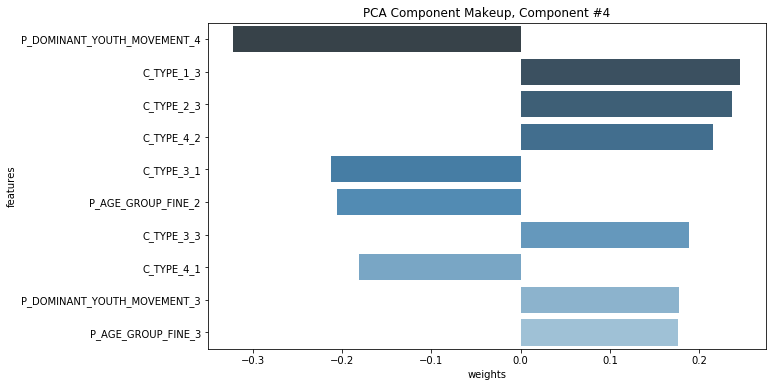

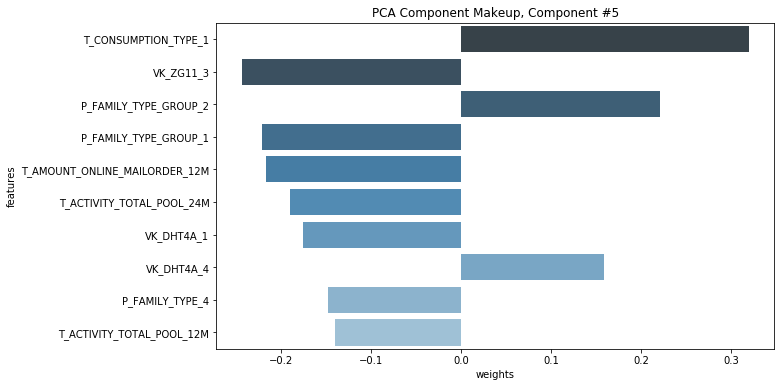

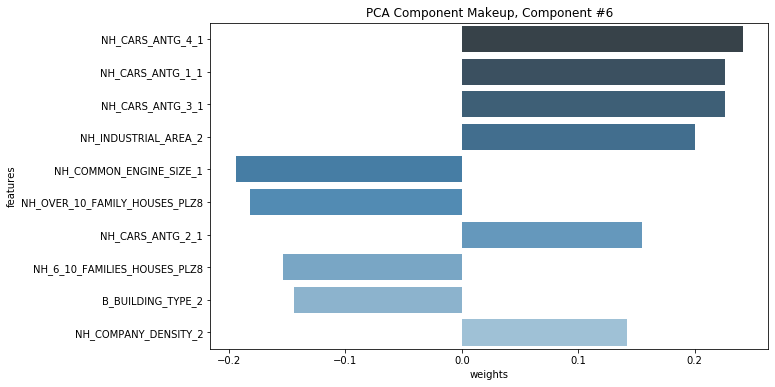

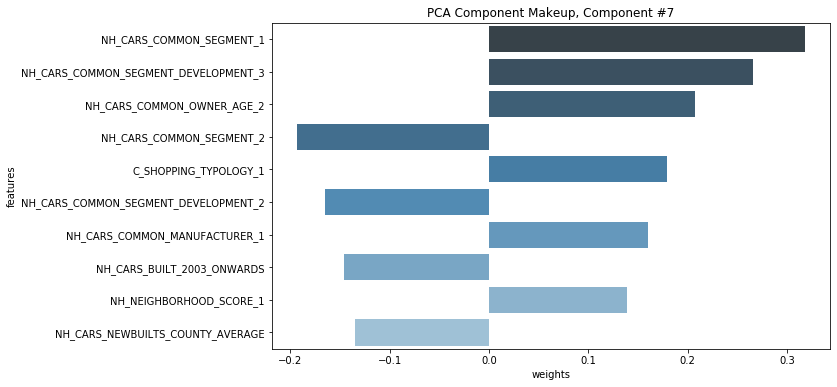

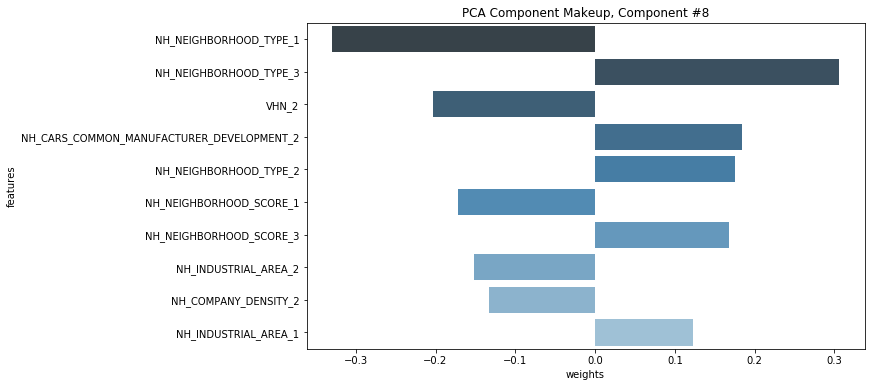

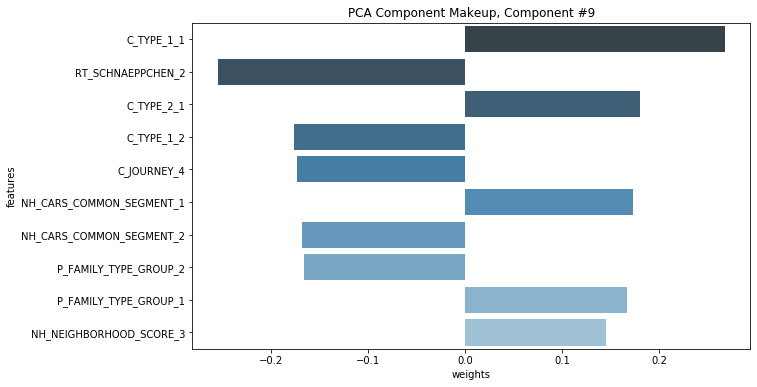

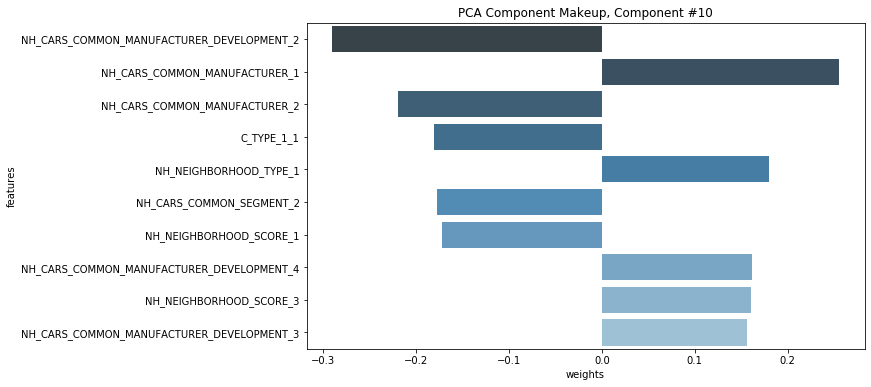

In [29]:
for n in range(10):
    num = 1+n
    display_component(mm_v, features_list, component_num=num, n_weights=10)

### Re-train model with desired number of features

In [30]:
# read data
azdias_mm = data_bucket.read_parquet('Udacity_AZDIAS_052018_mm.parquet')

# convert df to np array
train_data_np = azdias_mm.values.astype('float32')

# define number of components to preserve 85% of explained variance
n_components = mm_components
pca_SM = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=n_components,
             sagemaker_session=session)


# convert to RecordSet format
formatted_train_data = pca_SM.record_set(train_data_np)

In [31]:
%%time

# train the PCA mode on the formatted data
pca_SM.fit(formatted_train_data, logs=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 21:53:23 Starting - Starting the training job
2020-10-25 21:53:24 Starting - Launching requested ML instances...........
2020-10-25 21:54:28 Starting - Preparing the instances for training............
2020-10-25 21:55:31 Downloading - Downloading input data......
2020-10-25 21:56:08 Training - Downloading the training image..
2020-10-25 21:56:21 Training - Training image download completed. Training in progress...
2020-10-25 21:56:37 Uploading - Uploading generated training model
2020-10-25 21:56:43 Completed - Training job completed
CPU times: user 225 ms, sys: 5.9 ms, total: 231 ms
Wall time: 3min 21s


In [32]:
# save attributes from PCA model trained with normalized data
s, v = get_model_attributes(pca_SM, models_bucket)

s.to_csv('pca__s_%s' % pca_SM._current_job_name)
v.to_csv('pca__v_%s' % pca_SM._current_job_name)
job_name = pca_SM._current_job_name

models/pca-2020-10-25-21-53-23-019/output/model.tar.gz


In [33]:
print('Model job name: %s' % job_name)

Model job name: pca-2020-10-25-21-53-23-019


Component makeup for top 10 PCA components, normalized data

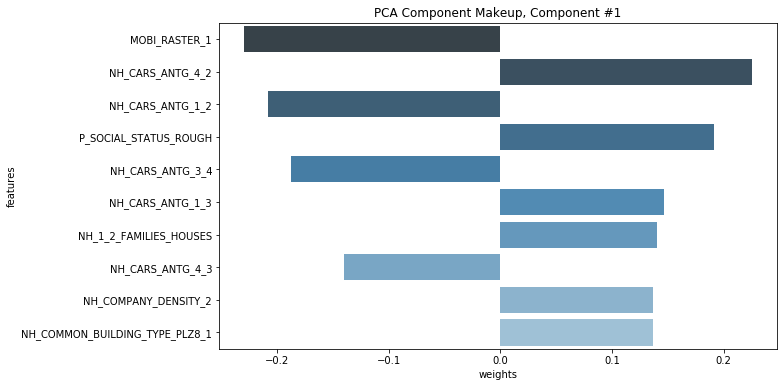

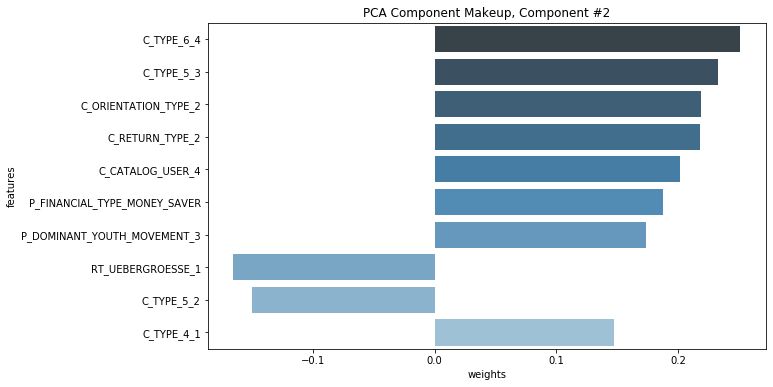

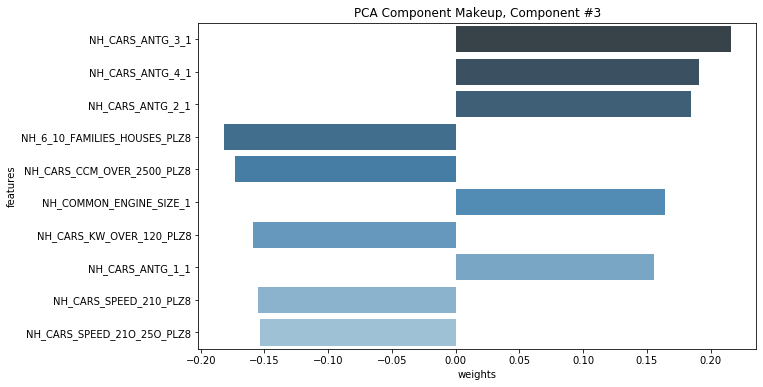

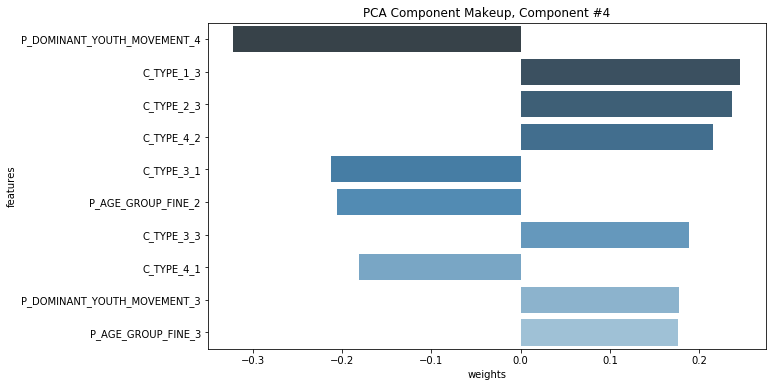

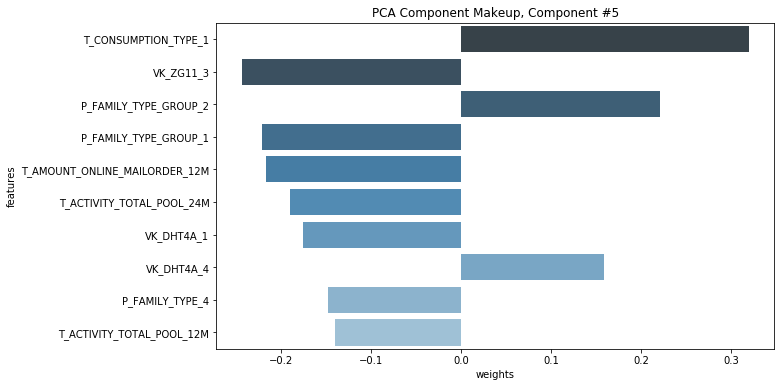

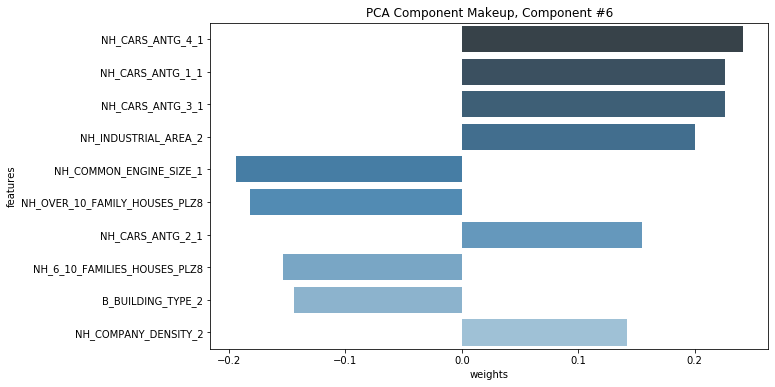

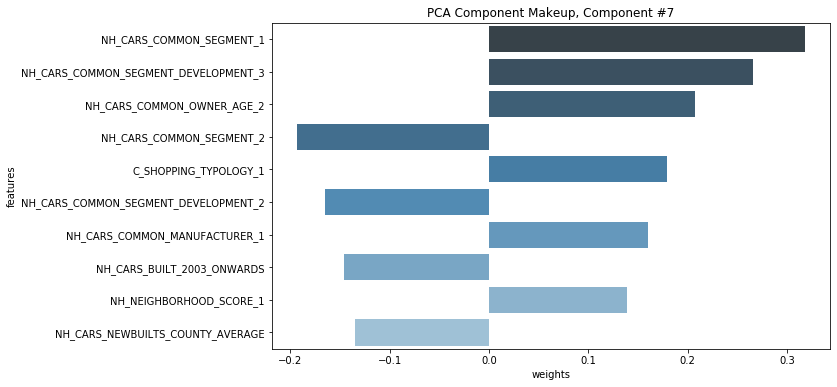

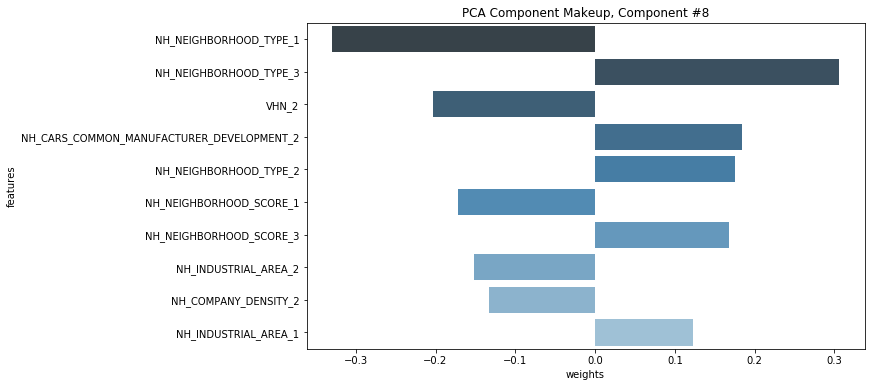

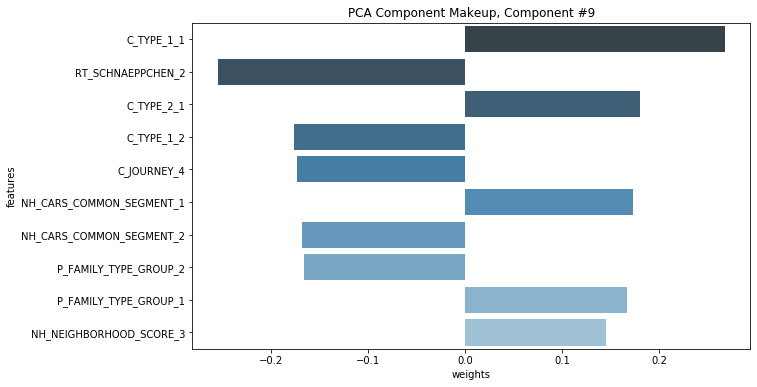

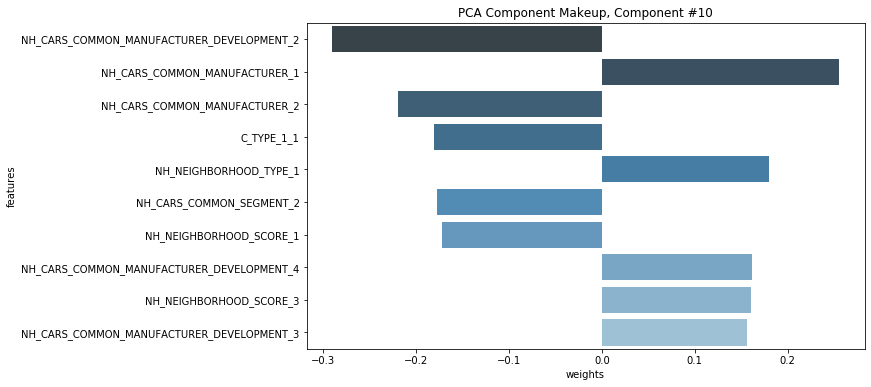

In [36]:
# set global variable N_COMPONENTS now that we have a new maximum
N_COMPONENTS = mm_components
for n in range(10):
    num = 1+n
    display_component(v, features_list, component_num=num, n_weights=10)

#### Deploying the PCA Model

We can now deploy this model and use it to make "predictions", that is, to transform data.


In [37]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                              instance_type='ml.t2.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!CPU times: user 249 ms, sys: 12.7 ms, total: 262 ms
Wall time: 6min 32s


Cleanup data

In [38]:
del formatted_train_data
del train_data_np

In [39]:
def create_transformed_df(pca_predictions, num_components):
    """
    Create a dataframe out of pca predictions, considering the given number of components
    ---
    Arguments
        pca_predictions: list
            A list of pca prediction responses
        num_components: int
            The number of top components to use.
    Returns
        transformed_df: pd.DataFrame
            The dataframe with transformed data
    """
    def pca_pred_to_array(prediction):
        """
        Transform a prediction from from sagemaker.PCA into a numpy array
        ---
        Arguments
            prediction: dict
                A dictionary with PCA prediction response
        Returns
            pca_array: np.array
                A numpy array with projected data
        """
        pca = [data.label['projection'].float32_tensor.values for data in prediction]

        return np.array(pca)

    # add descriptive columns
    PCA_list=['PCA_%d' % k for k in range(num_components)]
    
    # convert each prediction response a stack result list of predictions
    pca_data = np.vstack([pca_pred_to_array(prediction) for prediction in pca_predictions])

    # reverse columns, component order
    pca_data = pca_data[:, ::-1]

    transformed_df = pd.DataFrame(pca_data, columns = PCA_list)
    
    return transformed_df

In [40]:
def predict_and_save(file_prefix, pca_predictor, n_components, data_bucket, file_suffix, batch_size=1000):
    """
    Load data, make PCA transformation and save resulting dataframe
    ---
    Arguments
        file_prefix: string
            The file name prefix (without extension)
        pca_predictior: sagemaker.PCA
            Trained PCA predictor
        n_components: int
            Number of components
        data_bucket: BucketUtils
            Bucket instance where the data file is locate
        file_suffix: string
            A suffix to append to filename
        batch_size: int
            Size of batch for PCA prediction
    Returns
        None
    """
    # read data
    data = data_bucket.read_parquet('%s.parquet' % file_prefix)

    # convert df to np array
    data_np = data.values.astype('float32')
    
    # submit data in batches for pca transformation
    pca_data = []
    for i in range(len(data_np)//batch_size +1):
        predicted_pca = pca_predictor.predict(data_np[i*batch_size:(1+i)*batch_size])
        pca_data.append(predicted_pca)

    #cleanup data
    del data_np
    del data
    
    # transform data and save datafram
    df = create_transformed_df(pca_data, n_components)
    filename = '%s_pca_file_%s.parquet' % (file_prefix, file_suffix)
    data_bucket.save_parquet(df, filename)

    print('Dataframe save to %s' % filename)

### Apply PCA Transformation to datasets

In [41]:
predict_and_save('Udacity_CUSTOMERS_052018_mm', pca_predictor, mm_components, data_bucket, '', batch_size=1000)

Dataframe save to Udacity_CUSTOMERS_052018_mm_pca_file_.parquet


In [42]:
predict_and_save('Udacity_AZDIAS_052018_mm', pca_predictor, mm_components, data_bucket, '', batch_size=1000)

Dataframe save to Udacity_AZDIAS_052018_mm_pca_file_.parquet


In [43]:
predict_and_save('Udacity_MAILOUT_052018_TEST_mm', pca_predictor, mm_components, data_bucket, '', batch_size=1000)

Dataframe save to Udacity_MAILOUT_052018_TEST_mm_pca_file_.parquet


In [44]:
predict_and_save('Udacity_MAILOUT_052018_TRAIN_mm', pca_predictor, mm_components, data_bucket, '', batch_size=1000)

Dataframe save to Udacity_MAILOUT_052018_TRAIN_mm_pca_file_.parquet


#### Delete the Endpoint!

Now that we've deployed the model and created our new, transformed training data, we no longer need the PCA endpoint.

In [45]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

---
# Population Segmentation 

Now, we’ll use the unsupervised clustering algorithm, k-means, to segment General Population using their PCA attributes, which are in the transformed DataFrame we just created. We will then repeat the process for Customers data and compare the resulting groups.<br>
K-means is a clustering algorithm that identifies clusters of similar data points based on their component makeup.

We can use built-in SageMaker algorithm for [KMeans](https://sagemaker.readthedocs.io/en/stable/kmeans.html) to cluster data.

### Choosing a "Good" K

One method for choosing a "good" k, is to choose based on empirical data. A bad k would be one so *high* that only one or two very close data points are near it, and another bad k would be one so *low* that data points are really far away from the centers.

You want to select a k such that data points in a single cluster are close together but that there are enough clusters to effectively separate the data. You can approximate this separation by measuring how close your data points are to each cluster center; the average centroid distance between cluster points and a centroid. After trying several values for k, the centroid distance typically reaches some "elbow"; it stops decreasing at a sharp rate and this indicates a good value of k. The graph below indicates the average centroid distance for value of k between 2 and 12.

<img src='https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/11/06/k-means-sagemaker-3.gif' width=50% />

A distance elbow can be seen around 7 when the distance starts to increase and then decrease at a slower rate. This indicates that there is enough separation to distinguish the data points in each cluster, but also that you included enough clusters so that the data points aren’t *extremely* far away from each cluster.

#### Read data

In [46]:
# read pca model attributes
pca_model_name = 'pca-2020-10-25-21-53-23-019'
s = pd.read_csv('pca__s_%s' % pca_model_name)
v = pd.read_csv('pca__v_%s' % pca_model_name)

In [48]:
# read general population pca transformed data
general_pca = data_bucket.read_parquet('Udacity_AZDIAS_052018_mm_pca_file_.parquet')
general_pca.sample(7)

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_195,PCA_196,PCA_197,PCA_198,PCA_199,PCA_200,PCA_201,PCA_202,PCA_203,PCA_204
403193,-0.008535,-0.919839,-1.421541,-1.315404,-1.861518,0.486390,1.685771,0.624338,1.061985,0.065114,...,-0.105336,0.266164,0.302587,0.265300,0.012479,0.394119,-0.235814,0.059076,-0.077775,0.104806
302942,-0.534431,0.569384,0.075796,1.055803,0.800250,0.716161,0.820093,0.656924,0.064611,1.028085,...,-0.080471,0.050554,-0.817012,-0.362445,-0.044756,-0.019040,-0.003375,0.302052,-0.426828,-0.077009
519796,-2.065683,0.264439,-0.376632,0.778995,1.248441,1.338905,0.111895,0.297079,0.113631,-0.177077,...,0.280322,0.288281,0.334262,0.057278,-0.122194,0.041969,-0.048462,0.055686,0.130641,-0.220390
747442,-1.289710,-1.580844,0.794982,-0.896199,0.594183,-0.738880,0.109366,-0.684512,0.591518,-0.661404,...,0.637794,0.070659,0.342488,-0.305860,0.002649,-0.211615,0.564785,0.215648,0.176280,0.226566
158701,-2.496719,1.033263,0.815358,0.570059,0.290814,-1.003011,-0.480094,0.166206,-0.578422,0.086158,...,-0.177401,-0.033424,0.227610,0.111580,0.102452,-0.063499,-0.329896,-0.177002,-0.237229,-0.128768
299970,-2.430834,-2.009426,-0.823253,-0.548738,-0.788692,0.660525,-0.048018,0.991216,-0.982448,-0.504686,...,-0.068673,-0.263947,-0.374075,-0.297100,-0.351915,-0.402109,-0.123932,-0.023085,0.376863,-0.484989
210821,1.297508,1.060837,-0.550619,-0.809448,1.055571,-0.170543,0.245193,-0.815511,-0.070543,-0.722312,...,-0.374070,-0.196956,-0.001694,0.081038,-0.013595,-0.742298,-0.322591,-0.161411,-0.077472,-0.044751


#### Define a sample to estimate cluster size

In [49]:
data_size = len(general_pca)
sample_ratio = 0.3
sample_size = np.round(data_size*sample_ratio).astype(int)
print('Dataset size: %d, %.1f sample size: %d' % (data_size, sample_ratio, sample_size))

sample = general_pca.sample(sample_size, random_state=42)

Dataset size: 787617, 0.3 sample size: 236285


### Use elbow method to estimate number of clusters

In [53]:
def train_kmeans_and_get_elbow_coef(kmeans_train_data_np, bucket, num_clusters):
    """
    Train a kmeans model and compute elbow coefficient (distortion)
    ---
    Arguments
        kmeans_train_data_np: np.array
            Traning data in numpy array format
        bucket: BucketUtils
            Bucket were model artifacts will be stored
        num_clusters: int
            Number of clusters for kmeans model
    Returns
        distortion: float
            Distortion coefficient for clustered data
    """    
    global kmeans_formatted_data
    
    # define output path for model artifacts
    output_path='s3://{}/{}/elbow-k/{}/'.format(bucket.bucket_name, bucket.prefix, num_clusters)

    # create a kmeans model with given number of clusters
    kmeans = KMeans(role=role,
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path, # using the same output path as was defined, earlier
                    k=num_clusters)

    # ugly hack: relly on a global variable to avoid converting data into record_set in every round
    if kmeans_formatted_data is None:
        kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

    # fit model and hold job name
    kmeans.fit(kmeans_formatted_data, logs=False)
    training_job_name=kmeans._current_job_name

    # location of model artifacts
    model_key = '{}/elbow-k/{}/{}/output/model.tar.gz'.format(bucket.prefix, num_clusters, training_job_name)

    # download and unzip model
    boto3.resource('s3').Bucket(bucket.bucket_name).download_file(model_key, 'model.tar.gz')

    # unzipping as model_algo-1
    os.system('tar -zxvf model.tar.gz')
    os.system('unzip model_algo-1')
    
    # access model attributes and compute clusters distortion for given number of clusters
    kmeans_model = mx.ndarray.load('model_algo-1')
    kmeans_numpy = kmeans_model[0].asnumpy()
    distortion = sum(np.min(cdist(kmeans_train_data_np, kmeans_numpy, 'euclidean'), axis=1)) / len(kmeans_train_data_np)
    
    return distortion

In [54]:
# convert the transformed dataframe into numpy array
kmeans_train_data_np = sample.values.astype('float32')

# place holder for record_set data
kmeans_formatted_data = None

elbow_coefs = []
num_clusters = list(range(5, 20))

# train kmeans models for given number of clusters and store elbow coefficients
for num_cluster in num_clusters:
    elbow_coefs.append(train_kmeans_and_get_elbow_coef(kmeans_train_data_np, models_bucket, num_cluster))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:27:38 Starting - Starting the training job
2020-10-25 22:27:40 Starting - Launching requested ML instances............
2020-10-25 22:28:47 Starting - Preparing the instances for training...........
2020-10-25 22:29:47 Downloading - Downloading input data........
2020-10-25 22:30:28 Training - Downloading the training image.
2020-10-25 22:30:42 Training - Training image download completed. Training in progress.
2020-10-25 22:30:47 Uploading - Uploading generated training model.
2020-10-25 22:30:54 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:31:00 Starting - Starting the training job
2020-10-25 22:31:02 Starting - Launching requested ML instances................
2020-10-25 22:32:27 Starting - Preparing the instances for training................
2020-10-25 22:33:51 Downloading - Downloading input data...
2020-10-25 22:34:14 Training - Downloading the training image...
2020-10-25 22:34:34 Training - Training image download completed. Training in progress.
2020-10-25 22:34:39 Uploading - Uploading generated training model.
2020-10-25 22:34:46 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:34:52 Starting - Starting the training job
2020-10-25 22:34:56 Starting - Launching requested ML instances................
2020-10-25 22:36:22 Starting - Preparing the instances for training..................
2020-10-25 22:37:58 Downloading - Downloading input data...
2020-10-25 22:38:14 Training - Downloading the training image.
2020-10-25 22:38:28 Training - Training image download completed. Training in progress..
2020-10-25 22:38:34 Uploading - Uploading generated training model
2020-10-25 22:38:41 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:38:45 Starting - Starting the training job
2020-10-25 22:38:47 Starting - Launching requested ML instances.............
2020-10-25 22:39:56 Starting - Preparing the instances for training............
2020-10-25 22:41:01 Downloading - Downloading input data....
2020-10-25 22:41:29 Training - Downloading the training image..
2020-10-25 22:41:43 Training - Training image download completed. Training in progress..
2020-10-25 22:41:53 Uploading - Uploading generated training model
2020-10-25 22:42:00 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:42:03 Starting - Starting the training job
2020-10-25 22:42:05 Starting - Launching requested ML instances............
2020-10-25 22:43:11 Starting - Preparing the instances for training............
2020-10-25 22:44:15 Downloading - Downloading input data........
2020-10-25 22:45:02 Training - Downloading the training image..
2020-10-25 22:45:15 Training - Training image download completed. Training in progress.
2020-10-25 22:45:21 Uploading - Uploading generated training model
2020-10-25 22:45:28 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:45:31 Starting - Starting the training job
2020-10-25 22:45:34 Starting - Launching requested ML instances..............
2020-10-25 22:46:47 Starting - Preparing the instances for training...............
2020-10-25 22:48:08 Downloading - Downloading input data..
2020-10-25 22:48:25 Training - Downloading the training image..
2020-10-25 22:48:38 Training - Training image download completed. Training in progress..
2020-10-25 22:48:49 Uploading - Uploading generated training model
2020-10-25 22:48:55 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:48:59 Starting - Starting the training job
2020-10-25 22:49:00 Starting - Launching requested ML instances.................
2020-10-25 22:50:30 Starting - Preparing the instances for training...............
2020-10-25 22:51:52 Downloading - Downloading input data..
2020-10-25 22:52:09 Training - Downloading the training image..
2020-10-25 22:52:22 Training - Training image download completed. Training in progress..
2020-10-25 22:52:33 Uploading - Uploading generated training model
2020-10-25 22:52:40 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:52:41 Starting - Starting the training job
2020-10-25 22:52:44 Starting - Launching requested ML instances.................
2020-10-25 22:54:12 Starting - Preparing the instances for training.......
2020-10-25 22:54:56 Downloading - Downloading input data.........
2020-10-25 22:55:46 Training - Downloading the training image..
2020-10-25 22:55:59 Training - Training image download completed. Training in progress..
2020-10-25 22:56:10 Uploading - Uploading generated training model
2020-10-25 22:56:17 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:56:19 Starting - Starting the training job
2020-10-25 22:56:21 Starting - Launching requested ML instances............
2020-10-25 22:57:28 Starting - Preparing the instances for training............
2020-10-25 22:58:30 Downloading - Downloading input data.....
2020-10-25 22:59:04 Training - Downloading the training image..
2020-10-25 22:59:19 Training - Training image download completed. Training in progress...
2020-10-25 22:59:30 Uploading - Uploading generated training model
2020-10-25 22:59:37 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 22:59:41 Starting - Starting the training job
2020-10-25 22:59:43 Starting - Launching requested ML instances.............
2020-10-25 23:00:52 Starting - Preparing the instances for training.........
2020-10-25 23:01:45 Downloading - Downloading input data......
2020-10-25 23:02:18 Training - Downloading the training image..
2020-10-25 23:02:32 Training - Training image download completed. Training in progress.
2020-10-25 23:02:38 Uploading - Uploading generated training model
2020-10-25 23:02:45 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 23:02:49 Starting - Starting the training job
2020-10-25 23:02:51 Starting - Launching requested ML instances.............
2020-10-25 23:04:01 Starting - Preparing the instances for training.............
2020-10-25 23:05:10 Downloading - Downloading input data.......
2020-10-25 23:05:54 Training - Downloading the training image...
2020-10-25 23:06:13 Training - Training image download completed. Training in progress..
2020-10-25 23:06:23 Uploading - Uploading generated training model
2020-10-25 23:06:30 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 23:06:32 Starting - Starting the training job
2020-10-25 23:06:34 Starting - Launching requested ML instances................
2020-10-25 23:08:03 Starting - Preparing the instances for training..............
2020-10-25 23:09:13 Downloading - Downloading input data...
2020-10-25 23:09:35 Training - Downloading the training image..
2020-10-25 23:09:49 Training - Training image download completed. Training in progress..
2020-10-25 23:09:59 Uploading - Uploading generated training model
2020-10-25 23:10:06 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 23:10:10 Starting - Starting the training job
2020-10-25 23:10:11 Starting - Launching requested ML instances................
2020-10-25 23:11:38 Starting - Preparing the instances for training............
2020-10-25 23:12:46 Downloading - Downloading input data...
2020-10-25 23:13:03 Training - Downloading the training image...
2020-10-25 23:13:22 Training - Training image download completed. Training in progress.
2020-10-25 23:13:27 Uploading - Uploading generated training model
2020-10-25 23:13:34 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 23:13:38 Starting - Starting the training job
2020-10-25 23:13:40 Starting - Launching requested ML instances............
2020-10-25 23:14:48 Starting - Preparing the instances for training................
2020-10-25 23:16:14 Downloading - Downloading input data...
2020-10-25 23:16:31 Training - Downloading the training image..
2020-10-25 23:16:48 Training - Training image download completed. Training in progress..
2020-10-25 23:16:58 Uploading - Uploading generated training model.
2020-10-25 23:17:05 Completed - Training job completed


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 23:17:11 Starting - Starting the training job
2020-10-25 23:17:13 Starting - Launching requested ML instances.............
2020-10-25 23:18:22 Starting - Preparing the instances for training..................
2020-10-25 23:19:59 Downloading - Downloading input data.
2020-10-25 23:20:10 Training - Downloading the training image..
2020-10-25 23:20:24 Training - Training image download completed. Training in progress..
2020-10-25 23:20:35 Uploading - Uploading generated training model
2020-10-25 23:20:42 Completed - Training job completed


#### Elbow plot

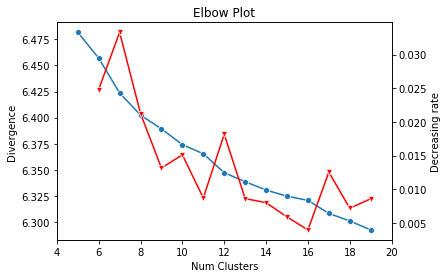

In [78]:
# compute delta between consecutive points (elbow coefficient decreasing rate)
deltas = [np.abs(elbow_coefs[i]-elbow_coefs[i-1]) for i in range(1, len(elbow_coefs))]

ax = sns.lineplot(num_clusters, elbow_coefs, marker='o')
ax.set_ylabel('Divergence')
ax.set_xlabel('Num Clusters')
ax.set_title('Elbow Plot')
_ = ax.set_xlim(4, 20)

ax2 = ax.twinx()
sns.lineplot(cluster_sizes[1:], deltas, marker='v', color='r', ax=ax2)
_ = ax2.set_ylabel('Decreasing rate')

Although we don't have a proeminent elbow, we ca observe a change in decreasing rate at 11 clusters

In [79]:
NUM_CLUSTERS = 11

### Train K-Means model using General Population data

In [80]:
# define a KMeans estimator
NUM_CLUSTERS = 11
output_path='s3://{}/{}/kmeans/'.format(models_bucket.bucket_name, models_bucket.prefix)

kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path=output_path, # using the same output path as was defined, earlier              
                k=NUM_CLUSTERS)


In [81]:
# convert the transformed dataframe into record_set data
kmeans_train_data_np = general_pca.values.astype('float32')
kmeans_formatted_data = kmeans.record_set(kmeans_train_data_np)

Train the k-means model

In [82]:
%%time
# train kmeans
kmeans.fit(kmeans_formatted_data, logs=False)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.



2020-10-25 23:34:00 Starting - Starting the training job
2020-10-25 23:34:02 Starting - Launching requested ML instances............
2020-10-25 23:35:10 Starting - Preparing the instances for training..................
2020-10-25 23:36:44 Downloading - Downloading input data...
2020-10-25 23:37:06 Training - Downloading the training image..
2020-10-25 23:37:20 Training - Training image download completed. Training in progress..
2020-10-25 23:37:30 Uploading - Uploading generated training model.
2020-10-25 23:37:37 Completed - Training job completed
CPU times: user 240 ms, sys: 11.8 ms, total: 252 ms
Wall time: 3min 41s


Keep model training job name

In [83]:
training_job_name = kmeans._current_job_name
print('Model name %s' % training_job_name)

Model name kmeans-2020-10-25-23-34-00-706


Deploy the trained model to create a kmeans_predictor

In [84]:
%%time
# deploy the model to create a predictor
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 299 ms, sys: 12.9 ms, total: 312 ms
Wall time: 8min 33s


### Predict cluster for General Population and Customers data

In [85]:
def get_kmeans_labels(kmeans_predictions):
    """
    Get cluster labels from kmeans predictions
    ---
    Arguments
        kmeans_predictions: list
            A list of kmeans prediction responses
    Returns
        cluster_labels: np.array
            An array of cluster labels from predictions
    """    
    def kmeans_pred_to_array(prediction):
        """
        Transform a prediction from from sagemaker.KMeans into a numpy array
        ---
        Arguments
            prediction: dict
                A dictionary with KMeans prediction response
        Returns
            pca_array: np.array
                A numpy array with closest cluster labels
        """
        cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in prediction]

        return np.array(cluster_labels)

    # get cluster labels for every batch of prediction and stack them into a single array
    cluster_labels = np.hstack([kmeans_pred_to_array(prediction) for prediction in kmeans_predictions])
    
    return cluster_labels

In [86]:
def predict_cluster_and_save(input_file_prefix, kmeans_predictor, data_bucket, output_file_prefix, batch_size=1000):
    """
    Load data, cluster it using k-Means, add cluster information and save dataframe
    ---
    Arguments
        input_file_prefix: string
            The file name prefix (without extension)
        kmeans_predictor: sagemaker.KMeans
            Trained KMeans predictor
        data_bucket: BucketUtils
            Bucket instance where the data file is locate
        output_file_prefix: string
            Filename prefix, before extension
        batch_size: int
            Size of batch for KMeans prediction
    Returns
        None
    """
    # Read data
    data = data_bucket.read_parquet('%s.parquet' % input_file_prefix)

    # convert df to np array
    data_np = data.values.astype('float32')
    
    # submit data in batches for kmeans prediction
    cluster_data = []
    for i in range(len(data_np)//batch_size +1):
        predicted = kmeans_predictor.predict(data_np[i*batch_size:(1+i)*batch_size])
        cluster_data.append(predicted)

    # create a 'Cluster' column with prediction
    cluster_labels = get_kmeans_labels(cluster_data)
    data['Cluster'] = cluster_labels
    
    # save dataframe
    filename = '%s.parquet' % output_file_prefix
    data_bucket.save_parquet(data, filename)

    print('Dataframe save to %s' % output_file_prefix)

In [87]:
predict_cluster_and_save('Udacity_AZDIAS_052018_mm_pca_file_', kmeans_predictor, data_bucket, 'Udacity_AZDIAS_052018_mm_pca_cluster')

Dataframe save to Udacity_AZDIAS_052018_mm_pca_cluster


In [88]:
predict_cluster_and_save('Udacity_CUSTOMERS_052018_mm_pca_file_', kmeans_predictor, data_bucket, 'Udacity_CUSTOMERS_052018_mm_pca_cluster')

Dataframe save to Udacity_CUSTOMERS_052018_mm_pca_cluster


#### Delete the Endpoint!

Now that we've deployed the k-means model and extracted the cluster labels for each data point, we no longer need the k-means endpoint.

In [101]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

## Exploring the resultant clusters

The resulting predictions should give us information about the cluster that each data point belongs to.

#### Read data

In [92]:
general_clusters = data_bucket.read_parquet('Udacity_AZDIAS_052018_mm_pca_cluster.parquet', columns=['Cluster'])
customer_clusters = data_bucket.read_parquet('Udacity_CUSTOMERS_052018_mm_pca_cluster.parquet', columns=['Cluster'])

### Visualize the distribution of data over clusters

Get the cluster labels for each of our data points (person) and visualize the distribution of points over each cluster.

In [94]:
# count number of entities in each cluster
general_counter = Counter(general_clusters.Cluster)
customer_counter = Counter(customer_clusters.Cluster)

In [95]:
# computer normalized propoportion for clusters occupancy
general_proportion = {k: v/len(general_clusters) for k, v in general_counter.items()}
customer_proportion = {k: v/len(customer_clusters) for k, v in customer_counter.items()}

In [96]:
# create a dataframe with clusters occupancy data for each population
general_df = pd.DataFrame.from_dict(general_proportion, orient='index').reset_index()
general_df['Population'] = 'General'
general_df.columns = ['Cluster', 'Proportion', 'Population']

customers_df = pd.DataFrame.from_dict(customer_proportion, orient='index').reset_index()
customers_df['Population'] = 'Customers'
customers_df.columns = ['Cluster', 'Proportion', 'Population']

df = pd.concat([general_df, customers_df])

# compute difference in clusters proportions between populations
diffs = {k: general_proportion[k]-customer_proportion[k] for k in general_proportion.keys()}
diff_df = customers_df = pd.DataFrame.from_dict(diffs, orient='index').reset_index()
diff_df.columns=['Cluster', 'ProportionDifference']

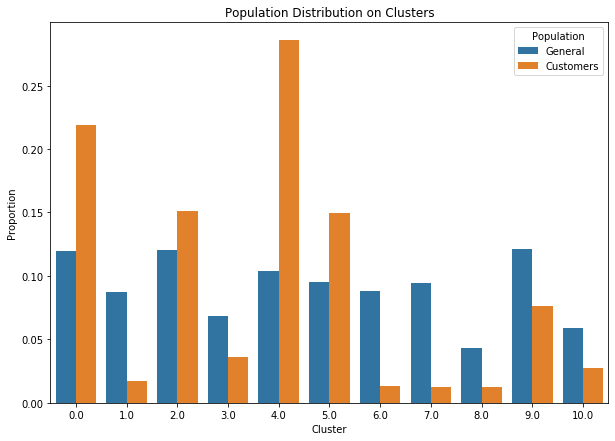

In [99]:
_, ax = plt.subplots(figsize=(10, 7))
ax.set_title('Population Distribution on Clusters')
_ = sns.barplot(x='Cluster', y='Proportion', hue='Population', data=df, ax=ax)

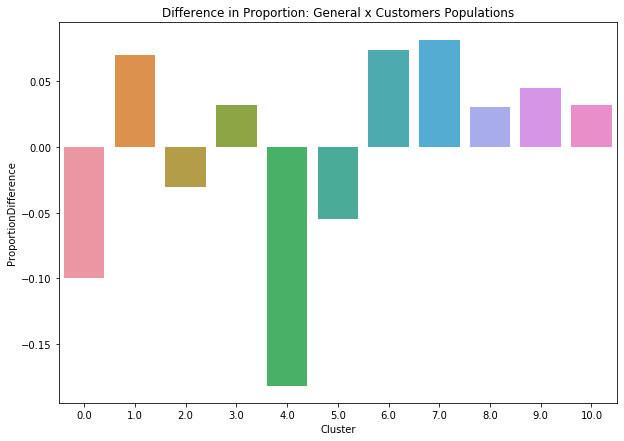

In [100]:
_, ax = plt.subplots(figsize=(10, 7))
_ = sns.barplot(x='Cluster', y='ProportionDifference', data=diff_df, ax=ax)
_ = ax.set_title('Difference in Proportion: General x Customers Populations')

We can observe that customers are proportionaly more frequent in clusters `0` and `4` and less frequent in clusters `1`, `6` and `7`.

---
## Model Attributes & Explainability

What do each of these clusters tell us about these data points? To improve explainability, we need to analyze the cluster centers. By combining PCA and k-means, and the information contained in the model attributes, we can identify which features characterize each cluster. This can help us learn about a population and remark patterns, based on the data.

In [102]:
# read list of features saved before PCA transformatino
features_list = utils.unpickle_obj('encoded_features_list')

In [103]:
# read pca transformed data with cluster infomation
general_clusters = data_bucket.read_parquet('Udacity_AZDIAS_052018_mm_pca_cluster.parquet', columns=['Cluster'])
customer_clusters = data_bucket.read_parquet('Udacity_CUSTOMERS_052018_mm_pca_cluster.parquet', columns=['Cluster'])

In [104]:
# read pca model attributes
pca_model_name = 'pca-2020-10-25-21-53-23-019'
s = pd.read_csv('pca__s_%s' % pca_model_name).drop(columns='Unnamed: 0')
v = pd.read_csv('pca__v_%s' % pca_model_name).drop(columns='Unnamed: 0')

### Explore KMeans Centroids

In [105]:
def get_kmeans_centroids(kmeans_job_name, bucket):
    """
    Load kmeans model attributes and extract centroids, in PCA projected space
    ---
    Arguments
        kmeans_job_name: string
            The kmeans training job name
        bucket: BucketUtils
            Bucket instance where model artifacts are locate
    Returns
        cluster_centroids: pd.DataFrame
            A dataframe with centroids in PCA projected space
    """
    # model artifacts location
    model_key = model_key='{}/kmeans/{}/output/model.tar.gz'.format(bucket.prefix, kmeans_job_name)

    print(model_key)

    # download and unzip model
    boto3.resource('s3').Bucket(bucket.bucket_name).download_file(model_key, 'model.tar.gz')

    # unzipping as model_algo-1
    os.system('tar -zxvf model.tar.gz')
    os.system('unzip model_algo-1')
    
    # loading the unzipped artifacts
    kmeans_model_params = mx.ndarray.load('model_algo-1')
    
    # get all the centroids and create a dataframe
    cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
    cluster_centroids.columns=['PCA_%d' % k for k in range(len(cluster_centroids.columns))]
    
    return cluster_centroids

#### Read kmeans centroids

In [106]:
kmeans_job_name = 'kmeans-2020-10-25-23-34-00-706'

centroids_df = get_kmeans_centroids(kmeans_job_name, models_bucket)
centroids_df

models/kmeans/kmeans-2020-10-25-23-34-00-706/output/model.tar.gz


,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_195,PCA_196,PCA_197,PCA_198,PCA_199,PCA_200,PCA_201,PCA_202,PCA_203,PCA_204
0,0.882872,1.777135,-0.473218,-0.682087,-0.124160,-0.289744,-0.248570,-0.039466,0.032833,-0.107232,...,0.002909,0.002359,-0.002148,0.010995,0.003503,-0.006371,0.002119,-0.003956,-0.000581,-0.013652
1,-0.777006,-1.311151,0.844473,-0.878336,0.504469,0.477089,0.136478,0.053900,0.023530,0.057344,...,-0.003212,0.005847,-0.002663,0.003815,-0.015513,0.001457,0.006769,0.001827,0.009974,-0.002559
2,1.655121,0.214565,-0.070198,1.079705,0.021380,-0.174290,-0.098166,-0.066686,0.188266,-0.121663,...,-0.003680,-0.003228,0.004230,-0.012546,0.002911,0.004022,0.003007,0.019645,0.018849,0.011313
3,-2.241322,0.966712,-0.904501,-0.002982,-0.510863,-0.218966,-0.028879,-0.171573,0.154441,-0.133655,...,0.003117,0.000158,0.004498,-0.022646,0.012361,0.003802,-0.003832,-0.004939,-0.002705,0.017246
4,0.045283,0.372443,0.982223,1.126014,0.437704,0.541915,0.065144,0.081527,-0.175618,0.178898,...,0.004268,-0.001512,0.000956,0.014261,-0.006351,-0.008417,0.000743,-0.006179,-0.006402,-0.010737
5,-0.737725,1.453501,0.714721,-0.710887,-0.232897,0.410769,0.031129,0.096987,0.295579,-0.003122,...,-0.005360,-0.012686,-0.007031,-0.001716,-0.000654,-0.000363,-0.001662,0.004028,-0.001864,0.007713
6,0.868664,-0.849038,-0.138749,-0.740108,0.887617,-0.301691,0.250267,0.039599,-0.476170,0.132605,...,-0.012487,-0.007116,0.000594,-0.017893,0.007031,0.015983,-0.013613,0.005315,-0.005272,0.010215
7,-2.013829,-1.688561,-0.559154,-0.193383,-0.172377,-0.475329,-0.020053,-0.156053,-0.067957,-0.116192,...,0.000404,0.002656,0.007974,0.011646,0.009184,-0.009338,0.009994,0.015046,0.008141,-0.018850
8,-0.081582,0.258004,-1.370706,1.061814,0.199368,0.896106,0.332349,0.270404,0.051254,0.290188,...,0.002712,0.011093,0.002240,-0.020710,0.000984,0.021044,-0.007462,-0.007412,-0.013178,0.000090
9,1.333336,-1.494771,0.037360,-0.410497,-0.498954,0.127884,-0.011586,0.022015,0.165666,-0.003824,...,0.008029,0.006577,-0.000152,0.004567,-0.007288,0.002254,-0.003535,-0.012291,-0.004192,0.009786


### Visualizing Centroids in Component Space

We can't visualize 205-dimensional centroids in space, but we could plot a heatmap of the centroids and their location in the transformed feature space. 

This would gives us insight into what characteristics define each cluster. Turns out that with such high number of features is hard to visualize them even in a heatmap. Let's focus instead on a heat map of top 10 features.

Heatmap of centroids considering top 10 features

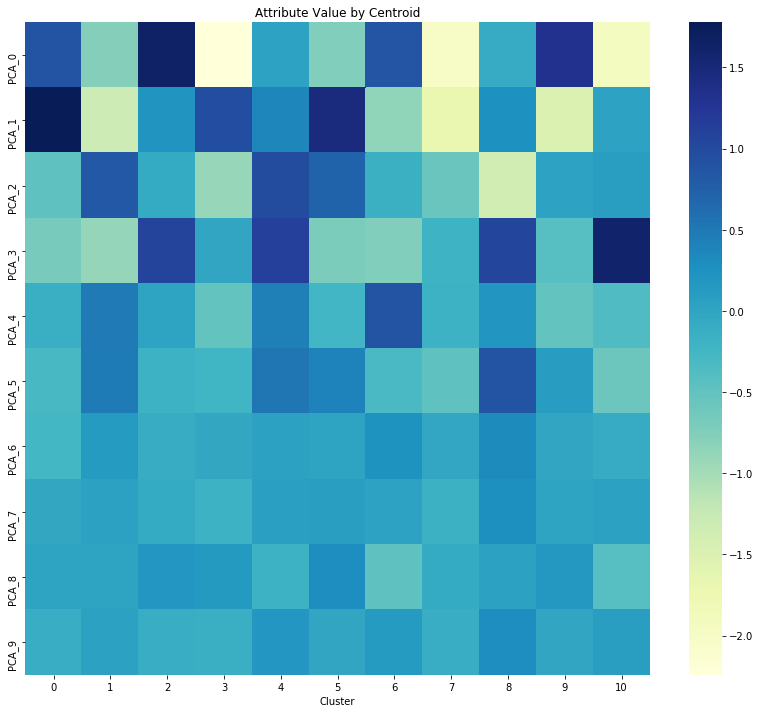

In [116]:
plt.figure(figsize = (14,12))
ax = sns.heatmap(centroids_df.iloc[:, :10].T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
#plt.yticks(fontsize = 16)
#plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

### Visualize Centroids in Original Space

In [107]:
import seaborn as sns

def display_centroids(v, centroids, features_list, cluster_numbers, n_features=10):
    """
    Display a chart with top n_features for centroids of given clusters, considering original space
    ---
    Arguments
        v: pd.DataFrame
            Dataframe with eigenvectors of PCA model
        centroids: pd.DataFrame
            Dataframe with clusters centroids
        feature_list: list
            List of features names in original space
        cluster_numbers: list
            List with clusters of interest
        n_features: int
            Number of features to display
    Returns
        None
    """
    V = v.values
    
    #project centroids back into original space
    original_space_centroids = []
    for cluster in cluster_numbers:
        original_centroid = np.dot(centroids.iloc[cluster].values, V.T)
        df = pd.DataFrame(np.expand_dims(original_centroid, axis=0), columns=features_list)
        df['Cluster'] = 'C_%d' % cluster
        original_space_centroids.append(df)
    df = pd.concat(original_space_centroids, axis=0)
    df = df.set_index('Cluster')
    
    # Sort by absolute values so we can display top n_features of interest
    df = df.transpose()
    df['Weights'] = df.apply(lambda e: max(abs(e)), axis='columns')
    df = df.sort_values(by='Weights', ascending=False).head(n_features+1).iloc[1:]
    df.drop(columns='Weights', inplace=True)

    # Perform some additional dataframe manipulations to display data on a chart
    dataframes = []
    for c in df.columns.values:
        cluster_df = pd.DataFrame(df[c])
        cluster_df.columns = ['Value']
        cluster_df['Cluster'] = c
        dataframes.append(cluster_df)
    df = pd.concat(dataframes, axis=0)
    df = df.reset_index()
    df.columns = ['Feature', 'Value', 'Cluster']

    # display using seaborn
    vertical_factor = n_features // 10
    _, ax=plt.subplots(figsize=(10,6*vertical_factor))
    sns.barplot(data=df,
                y='Feature',
                x='Value',
                hue="Cluster", 
                palette="Blues_d",
                ax=ax
               )
    ax.set_title('Cluster Centroids (Top Features)')
    plt.show()

#### Customers are more frequent on clusters `0` and `4`

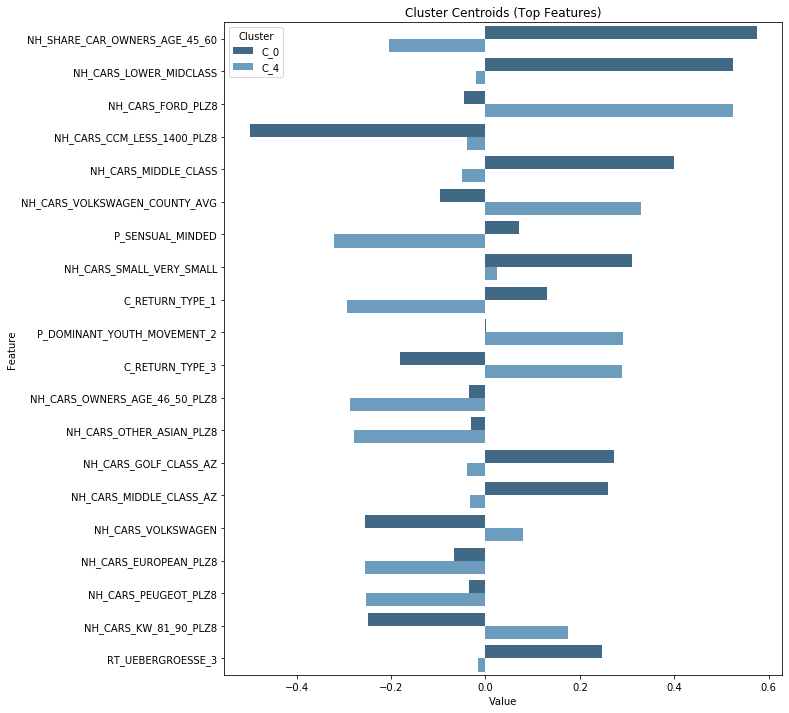

In [108]:
display_centroids(v, centroids_df, features_list, cluster_numbers=[0, 4], n_features=20)

**Cluster 0**

Influenceable customers (with respect to return type) from neighborhood with middle and lower-mid class cars and a share of car owners with ages between 45 and 60.

**Cluster 4**

Incentive-receptive (with respect to return type) people from neigborhood with predominance of Ford or Volkavagen cars (instead of other European or Asian cars), from reconstruction years (dominant youth movement).

#### Customers are less frequent on clusters `1`, `6` and d `7`

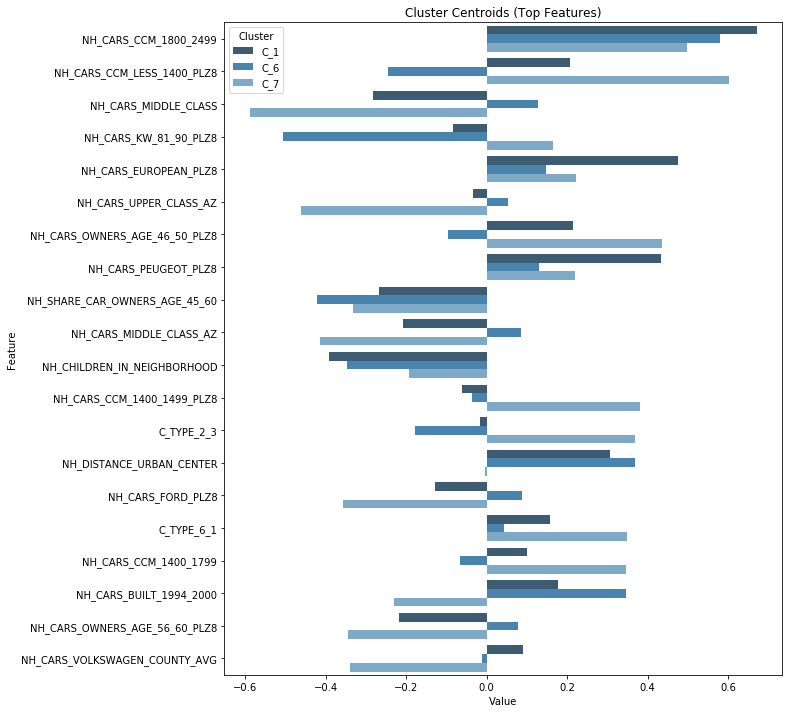

In [109]:
display_centroids(v, centroids_df, features_list, cluster_numbers=[1, 6, 7], n_features=20)

### Conclusion

We can use unsupervised methods to explore data and unconver hidden patterns.

In this project, we explored detailed (yeat not clean) demographics data from both general German and existing customers populations in order to identify potential new customers. 

First we reduced the features dimensionaty to a more manageable projected space (reducing features colinearity and the curse of dimensionalty). After that we grouped the General German population into groups without any previous criteria and use the same model to classify Customers population into the same groups (clusters).

Finally, we looked at the composition of the centroids of the clusters of interest in an attemp to provide human explanainability and identify potential new users.